

*   Camila Andrea Urrego Calderon
*   Juan Diego Cuadros Rodríguez



Se importan las librerias que se necesitan para todo el taller, con el fin de no llamar librerias durante el proceso

In [893]:
%pip install --quiet yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import seaborn as sns
import cvxpy as cp
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

Definimos nuestras variables de inicio, con el fin de facilitar el proceso

In [894]:
assets = ['BA','JNJ','CRM','MMM','GS']
start = '2017-12-01'
finish = '2022-12-31'
interval = '1Mo'
ind = '^DJI'

In [895]:
yf.pdr_override() # Utilizamos pdr_override() para que DataReader tome la estructura de yfinance

prices = web.DataReader(assets, start = start, end = finish, interval = interval)['Adj Close']
index = web.DataReader(ind, start = start, end = finish, interval = interval)['Adj Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [896]:
# Obtenemos los retornos del indice de mercado, que en este caso es el Dow Jones y los de los activos
ret_shares = np.log(prices/prices.shift(1)).dropna()
ret_index = np.log(index/index.shift(1)).dropna()

# Punto 1

In [897]:
# Creamos un ciclo para que itere sobre los retornos de cada activo y encuentre 
# el valor del del beta y el r-squared de cada acción a traves de MCO
betas = []
rs = []
for i in range(5):
  
  y = ret_shares[ret_shares.columns[i]] # Se itera a traves de los nombres de cada columna del DataFrame
  x = ret_index
  x = sm.add_constant(x)

  model = sm.OLS(y, x).fit() 
  b = model.params[1]
  p = model.rsquared
  betas.append(b)
  rs.append(p)

In [898]:
ret_e = ret_shares.mean()
vol = ret_shares.std()
ret_i = ret_index.mean()

In [899]:
# Con el fin de obtener el retorno del modelo CAPM se creo un ciclo
# este ciclo intera sobre el vector de betas creado anteriormente, del que tiene cada activo,
# con el fin de hacer el cálculo con cada beta
ret_CAPM = []
for i in range(5):
  rpar = ret_i * betas[i]
  ret_CAPM.append(rpar)

In [900]:
model_data = pd.DataFrame([vol,ret_e])

In [901]:
rCAPM = pd.DataFrame(ret_CAPM).T # se transpone para que puenda integrase con la tabla
rCAPM.columns = model_data.columns

In [902]:
model_data = pd.concat([model_data,rCAPM], axis = 0)

In [903]:
rsquared = pd.DataFrame(rs).T
rsquared.columns = model_data.columns

In [904]:
betas_df = pd.DataFrame(betas).T
betas_df.columns = rsquared.columns

In [905]:
model_data = pd.concat([model_data,rsquared,betas_df], axis = 0)

In [906]:
model_data.index = ["Volatility","E(r)","E(CAPM)","R-Squared","Betas"] # se crea el indice para indentificar cada media

In [907]:
model_data

,BA,CRM,GS,JNJ,MMM
Volatility,0.140849,0.092825,0.092545,0.051181,0.069501
E(r),-0.006482,0.004334,0.006664,0.006112,-0.008428
E(CAPM),0.008668,0.005188,0.006996,0.002914,0.005045
R-Squared,0.455279,0.375538,0.686943,0.389592,0.633436
Betas,1.772762,1.061091,1.430769,0.595903,1.031807


Es de destacar que la acción con mayor nivel de riesgo es Boeing (BA), debido a su ciclicidad y al momento actual del mercado. Por otro lado, se observa que el modelo CAPM no logra identificar todo el riesgo de Salesforce (CRM) y Jhonson and Jhonson (JNJ), expresado en la determinación. Por lo tanto se recomienda tener más objetos para identificar el valor de la acción

In [908]:
# Inputs para determinar la relación riesgo-retorno de cada activo
mu = ret_CAPM
be = model_data.loc['Betas']

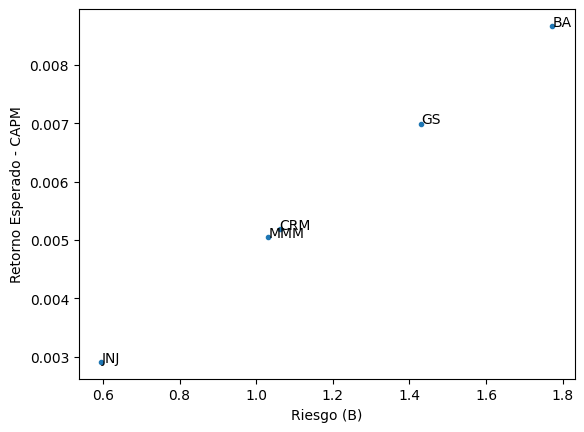

In [909]:
# se ubican los activos con cordenadas
plt.plot(be,mu,'.') 
# se crea un ciclo para que anote y el Ticker de cada activo junto a su ubicación
for i in range(len(mu)):
  plt.annotate(model_data.columns[i],(be[i],mu[i]))
plt.ylabel("Retorno Esperado - CAPM")
plt.xlabel("Riesgo (B)")
plt.show()

Segun la teoria, a mayor riesgo (**sistematico o no sistematico**), se espera un mayor retorno por parte del activo. Por lo tanto, el comportamiento visto la gráfica anterior concluye que la teoria es cierta

Se importa la base del modelo Fama-French con la fechas de los retornos de la acción

In [910]:
FF_3F = pd.read_csv('/content/FF_3F.csv',index_col=0,sep=';') # se coloca un indice temporal

In [911]:
FF_3F.index = ret_shares.index # se ubica el nuevo indice y se tiene la base para operar

In [912]:
betas_CAPM_FF = []
# se crea un ciclo para obtener los betas de cada activo
for i in range(5):

  yff = ret_shares[ret_shares.columns[i]] # se itera sobre las columnas 
  xff = FF_3F['Mkt-RF']
  xff = sm.add_constant(xff)

  model_ff = sm.OLS(yff, xff).fit() 
  bff = model_ff.params[1]*100
  betas_CAPM_FF.append(bff)

In [913]:
Fama_CAPM = pd.DataFrame(betas_CAPM_FF)
Fama_CAPM.index = model_data.columns
Fama_CAPM.columns = ['CAPM']

In [914]:
Fama_CAPM

,CAPM
BA,1.465518
CRM,1.125963
GS,1.352786
JNJ,0.496272
MMM,0.931743


In [915]:
betas_FF_3F = []
# se crea un ciclo para obtener los coeficientes del modelo Fama-Frech, con los retornos de las acciones
# y los elementos de modelo, con la estimación utilizando MCO
for i in range(5):

  yff_3f = ret_shares[ret_shares.columns[i]] # se itera sobre las columnas 
  xff_3f = FF_3F[['Mkt-RF','SMB','HML']]
  xff_3f = sm.add_constant(xff_3f)

  model_ff_3f = sm.OLS(yff_3f, xff_3f).fit() 
  bff_3f_1 = model_ff_3f.params[1]
  bff_3f_2 = model_ff_3f.params[2]
  bff_3f_3 = model_ff_3f.params[3]
  betas_FF_3F.append([bff_3f_1,bff_3f_2,bff_3f_3])

In [916]:
Fama = pd.DataFrame(betas_FF_3F)*100 #Se multiplica por 100 para obtener los valores reales de los coeficientes

In [917]:
Fama.columns = ['Mkt-RF','SMB','HML']

In [918]:
Fama.index = model_data.columns

In [919]:
Fama

,Mkt-RF,SMB,HML
BA,1.341208,0.676200,0.780206
CRM,1.155853,-0.078574,-0.541905
GS,1.315880,0.139644,0.489346
JNJ,0.549963,-0.394253,0.093956
MMM,0.942959,-0.124227,0.196195


In [920]:
pd.concat([Fama['Mkt-RF'],Fama_CAPM['CAPM']], axis=1)

,Mkt-RF,CAPM
BA,1.341208,1.465518
CRM,1.155853,1.125963
GS,1.315880,1.352786
JNJ,0.549963,0.496272
MMM,0.942959,0.931743


Es de destacar que bajo el modelo CAPM, se obtiene una mayor proporción de riesgo, gracias a la inclusión de nuevos datos en Fama-French, que le quita valor la riesgo de mercado y le da más valor a los demás coeficientes

# Punto 2

Se importan los datos base para el punto con la lista de activos dada

In [921]:
assets2 = ['KO','INTC','CAT','VZ','IBM']

In [922]:
yf.pdr_override() # Utilizamos pdr_override() para que DataReader tome la estructura de yfinance

prices2 = web.DataReader(assets2, start = start, end = finish, interval = interval)['Adj Close'] # Reciclamos los datos

[*********************100%***********************]  5 of 5 completed


In [923]:
ret_shares2 = np.log(prices2/prices2.shift(1)).dropna()

In [924]:
# Obtenemos lo elementos base para el procreso de optimización del portafolio
mu = ret_shares2.mean()
cov = ret_shares2.cov()

In [925]:
n = len(mu)
x = cp.Variable(n)
objetive = cp.Minimize(cp.quad_form(x,cov)) # Se optimiza para obtener los pesos
constraints = [x @ mu == 1, x>=0] # Restricción en corto
prob = cp.Problem(objetive,constraints)
prob.solve()
pt_sharpe = round(pd.DataFrame(x.value/sum(x.value)),2) # Dado para optener los pesos del portafolio de Sharpe
pt_sharpe.index = ret_shares2.columns

In [926]:
# Se crean las medidas estandar del portafolio
rpt = pd.DataFrame(pt_sharpe.T @ mu)
vol_pt = np.sqrt(pt_sharpe.T @ cov @ pt_sharpe)
# Se unen para poder ver los datos del portafolio tangete de Sharpe
sharpe = pd.concat([rpt,vol_pt],axis = 1)
sharpe.index = ['Wpt']
sharpe.columns = ['E(r)',"Vol"]
sharpe

,E(r),Vol
Wpt,0.008323,0.054463


<Axes: >

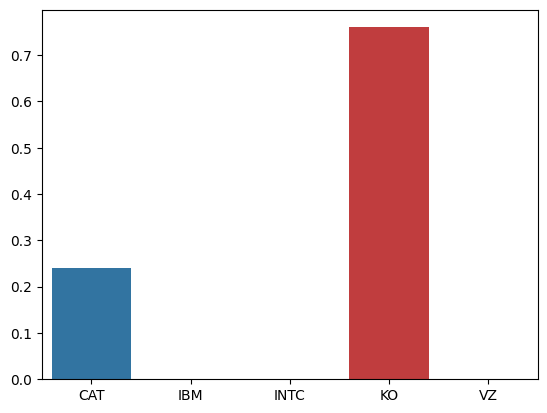

In [927]:
sns.barplot(pt_sharpe.T)

Los dos acciones que toma el portadolio de Sharpe se basan en los fundamentales de la relación riesgo retorno, por tanto, Coca Cola (KO) y Caterpillar (CAT), son elegidos como las acciones a elegir, por su rendimiento y bajo riesgo, dado que son acciones defensivas 

VaR of Portfolio

In [928]:
from scipy.stats import norm

### Parametrico

In [929]:
def VaR_p(confidence,sigma,mu):
  " la función es creada para obtener el VaR parametrico de un activo financiero "
  " dado un nivel de confianza y la volatilidad junto con su media "
  z = norm.ppf(confidence,loc = 0,scale = 1)
  por = mu-z*sigma
  return(por)

In [930]:
VaR_p(0.95,vol_pt,rpt) # VaR con alpha 5%

,0
0,-0.081261


Hay un 8.12% de la inversión en riesgo con un grado de confianza de 95%, si se decide invertir en el portafolio

In [931]:
VaR_p(0.99,vol_pt,rpt) # VaR con alpha 1%

,0
0,-0.118377


Hay un 11.83% de la inversión en riesgo con un grado de confianza de 99%, si se decide invertir en el portafolio

### Historico

In [932]:
# VaR historico a partir de la distribución de retornos al 5% de significancia
norm.ppf(0.05,rpt)*vol_pt 

,0
0,-0.089131


Bajo el historico de retornos y con una significancia de 5%, se revela que el 8.91% estaria en riesgo de perdida

In [933]:
# VaR historico a partir de la distribución de retornos al 1% de significancia
norm.ppf(0.01,rpt)*vol_pt

,0
0,-0.126247


Bajo el historico de retornos y con una significancia de 1%, se revela que el 12.62% estaria en riesgo de perdida

In [1013]:
dist=ret_shares2@pt_sharpe # Con el fin de un valor real en la distribución
promedio= dist.mean() #Pormedio de esa distribucion
sigma1= dist.std()

In [1014]:
portafolios =np.random.normal(promedio,sigma1,10000)
simulacion=np.percentile(portafolios,5)
simulacion

-0.0804902500088199

Con base en la simulación hecha se puede concluir que el valor en riesgo en el portafolio de Sharpe es de 8.04% 

# Punto 3

In [934]:
assets = ('MCD')
prices = yf.download(assets, start="2017-01-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos = np.log(prices/prices.shift()).dropna()
prices

[*********************100%***********************]  1 of 1 completed


Date
2017-01-01    105.551170
2017-02-01    109.925842
2017-03-01    112.435204
2017-04-01    121.387711
2017-05-01    130.895325
                 ...    
2022-08-01    248.069107
2022-09-01    228.130585
2022-10-01    269.576508
2022-11-01    269.705048
2022-12-01    262.017181
Name: Adj Close, Length: 72, dtype: float64

In [935]:
S0 = prices[71:72][0]
S0

262.0171813964844

In [936]:
mu = (retornos.mean())*12
sigma = (retornos.std())*np.sqrt(12)
NS = 10000 # No. trayectorias
T = 1
M = 12

In [937]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [938]:
M = 12 # Partición del año en días
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

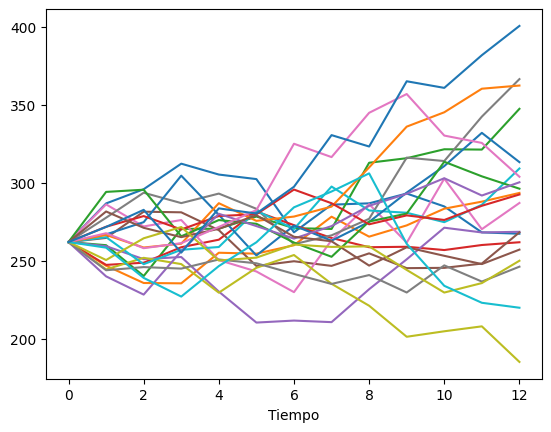

In [939]:
plt.plot(np.transpose(St[:21])) 
plt.xlabel("Tiempo")

In [940]:
St[:,-1].mean() 

305.7179128589575

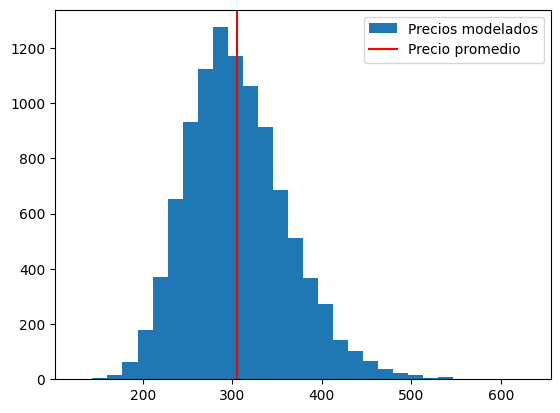

In [941]:
# Precio modelado en T
plt.hist(St[:,-1], bins=30, label='Precios modelados')
plt.axvline(St[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

La distribución de la grafica se encuentra sesgada hacia la izquierda y con algunas dispersiones de los datoscon valores mayores

In [942]:
St[:,-1].mean() # Valor esperado de la simulación

305.7179128589575

In [943]:
S0 * np.exp(mu * T) # Valor proyectado de la simulación

305.53981210849537

In [944]:
X = St[:,-1]
prob = len(X[X<S0])/NS # Poner que los retornos son menores que el dato inicial
prob # Probabilidad de precio menor a a la partida

0.2264

Se puede concluir que existen que hay una probabilidad de 22.59% de que los posibles retornos sean menores que mis datos base

#Punto 4

In [945]:
mu = 3
sigma = 0.3
NS = 10000 # No. trayectorias
T = 1
S0 = 100 

In [946]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [947]:
M = 12 # Partición del año en días
St = PathsGBM(S0,mu,sigma,T,NS,M)

In [948]:
St1 = PathsGBM(S0,mu,sigma,T,10,M)

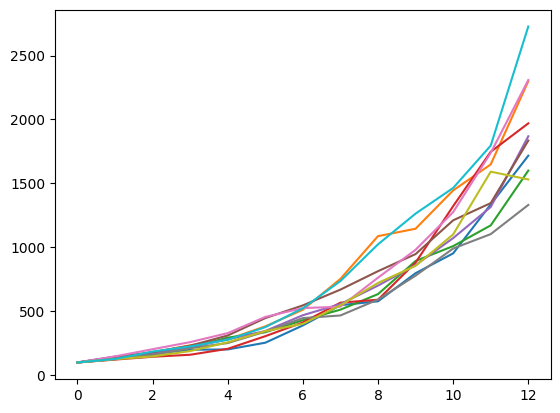

In [949]:
plt.plot(np.transpose(St1)) 

PRUEBA UHLENBECK

In [950]:
def prof_or_oh(x0, mu, sigma, k, T, dt, ns):

    steps = int(T/dt)
    y = np.zeros((ns, steps))
    for i in range(ns):
        x = np.zeros(steps)
        x[0] = x0
        for j in range(1, steps):
            x[j] = x[j-1] + k*(mu-x[j-1])*dt + sigma*np.sqrt(dt)*np.random.normal()
        y[i] = x
    return y

In [951]:
x0 = 1              
mu = 3               
sigma = 0.3   
M = 60       
k = 1               
T = 5                
dt = T/M         
ns = 10000           

In [952]:
y = prof_or_oh(x0, mu, sigma, k, T, dt, ns)

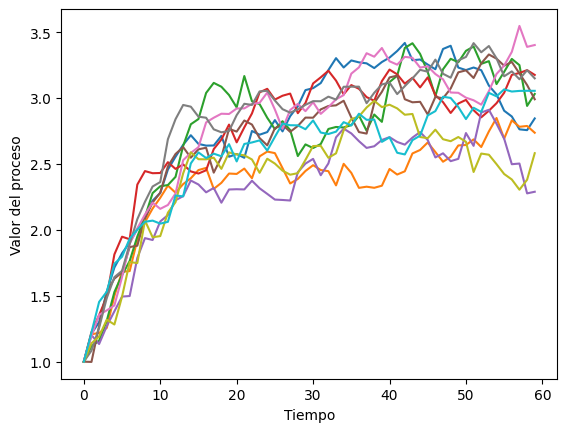

In [953]:
plt.plot(np.transpose(y[:10]))
plt.xlabel("Tiempo")
plt.ylabel("Valor del proceso")
plt.show()

Con base en el proceso anterior, se puede concluir que el desempeño del activo será positivo en el tiempo, con una varianza que cambia despues de 2 años y medio

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 1.]),
 array([2.28907603, 2.32617758, 2.36327914, 2.40038069, 2.43748225,
        2.4745838 , 2.51168536, 2.54878691, 2.58588847, 2.62299002,
        2.66009158, 2.69719313, 2.73429469, 2.77139624, 2.8084978 ,
        2.84559935, 2.88270091, 2.91980246, 2.95690402, 2.99400558,
        3.03110713, 3.06820869, 3.10531024, 3.1424118 , 3.17951335,
        3.21661491, 3.25371646, 3.29081802, 3.32791957, 3.36502113,
        3.40212268]),
 <BarContainer object of 30 artists>)

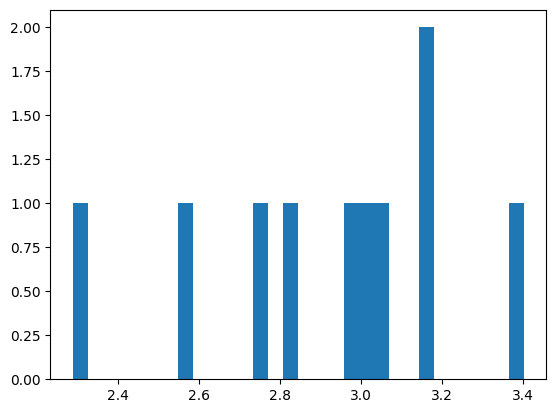

In [954]:
plt.hist(y[:10,-1], bins = 30)

Segun el histograma de los datos, lo simulación tendria una probabilidad uniforme y con valores especificos como resultado de la prueba, destacando el 3.1, como valor más común, segun la distribución

In [955]:
r0 = 0.03              
mu_r = 0.05               
sigma_r = 0.15   
M_r = 12       
k_r = 1               
T_r = 1                
dt_r = T_r/M_r         
ns_r = 100  

In [956]:
# Simulación del proceso
y = prof_or_oh(r0, mu_r, sigma_r, k_r, T_r, dt_r, ns_r)

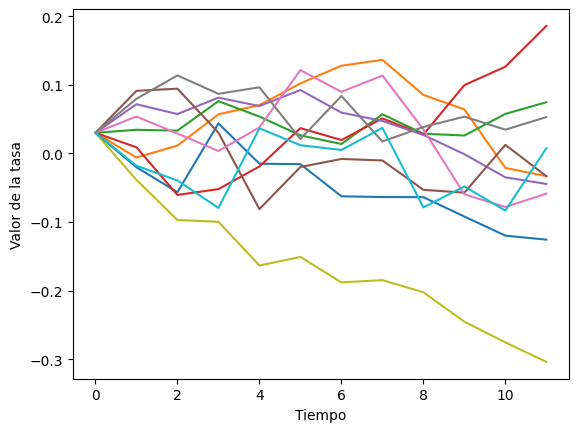

In [957]:
plt.plot(np.transpose(y[:10])) # Genera 10 trayectorias
plt.xlabel("Tiempo")
plt.ylabel("Valor de la tasa")
plt.show()

# Punto 5

In [958]:
assets_ia = ['KC=F','NG=F','HG=F'] # Cafe, Brent, Gold
start_ia = '2005-01-01'
end_ia = '2022-12-31'
interval_ia = '1Mo'

In [959]:
yf.pdr_override()

prices_ia = web.DataReader(assets_ia, start = start_ia, end = end_ia, interval = interval_ia)['Adj Close']

[*********************100%***********************]  3 of 3 completed


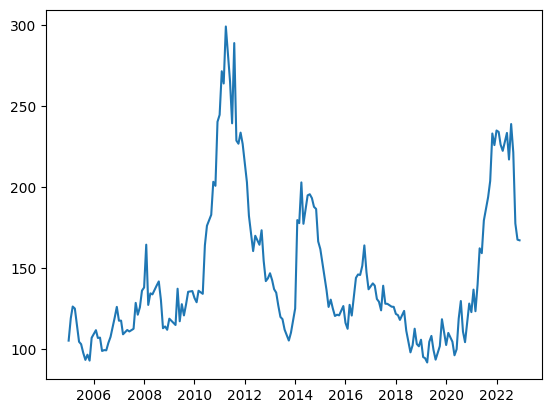

In [960]:
fig,ax=plt.subplots()
ax.plot(prices_ia['KC=F']) # Se deben eliminar los nan
plt.show()

In [961]:
pruebadf1 = adfuller(prices_ia['KC=F'].dropna()) # Prueba ADF para difinir concretar la estacionalidad
print("ADF test: %f" % pruebadf1[0]) 
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -3.329256
P-value: 0.013620
Citical values:
	1%: -3.467420
	5%: -2.877826
	10%: -2.575452


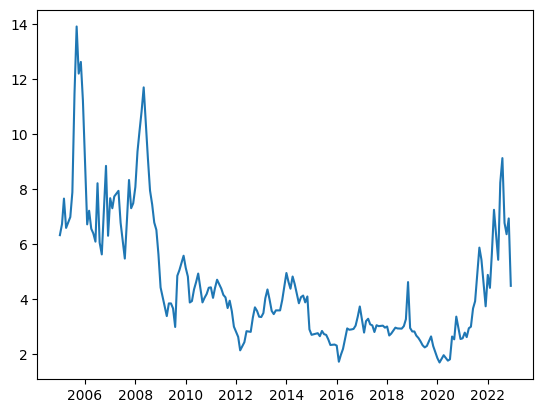

In [962]:
fig,ax=plt.subplots()
ax.plot(prices_ia['NG=F'])
plt.show()

In [963]:
pruebadf1 = adfuller(prices_ia['NG=F']) # Prueba ADF para difinir concretar la estacionalidad  
print("ADF test: %f" % pruebadf1[0])
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -3.157328
P-value: 0.022591
Citical values:
	1%: -3.468280
	5%: -2.878202
	10%: -2.575653


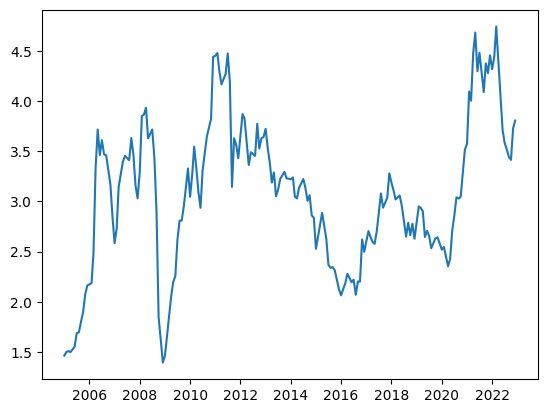

In [964]:
fig,ax=plt.subplots()
ax.plot(prices_ia['HG=F'])
plt.show()

In [965]:
pruebadf1 = adfuller(prices_ia['HG=F'].dropna()) # Prueba ADF para difinir concretar la estacionalidad 
print("ADF test: %f" % pruebadf1[0])
print("P-value: %f" % pruebadf1[1])
print("Citical values:")
for key, value in pruebadf1[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -3.058196
P-value: 0.029806
Citical values:
	1%: -3.466598
	5%: -2.877467
	10%: -2.575260


Todas las series son estacionarias

In [966]:
prices_ia.columns = ['Coffe','Natural Gas','Copper']

In [967]:
# Inputs del modelo
S0_5 = prices_ia[len(prices_ia)-1:len(prices_ia)]           
mu_5 = prices_ia.mean()              
sigma_5 = prices_ia.std()
M_5 = 12       
k_5 = 1               
T_5 = 1                
dt_5 = T_5/M_5         
NS_5 = 100  

In [973]:
YCOF = prof_or_oh(S0_5['Coffe'], mu_5[0], sigma_5[0], k_5, T_5, dt_5, NS_5)

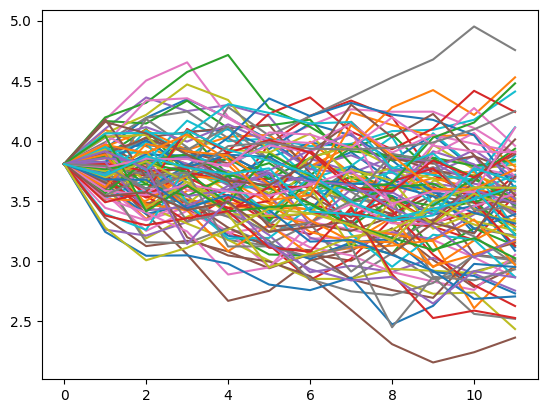

In [988]:
plt.plot(YCOF.T) 

In [975]:
YNG = prof_or_oh(S0_5['Natural Gas'], mu_5[1], sigma_5[1], k_5, T_5, dt_5, NS_5)

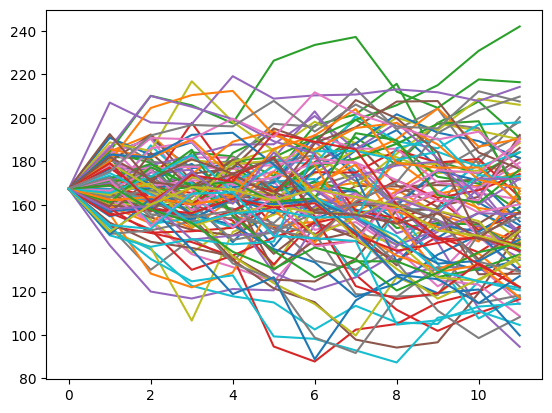

In [987]:
plt.plot(YNG.T)

In [976]:
YCOP = prof_or_oh(S0_5['Copper'], mu_5[2], sigma_5[2], k_5, T_5, dt_5, NS_5)

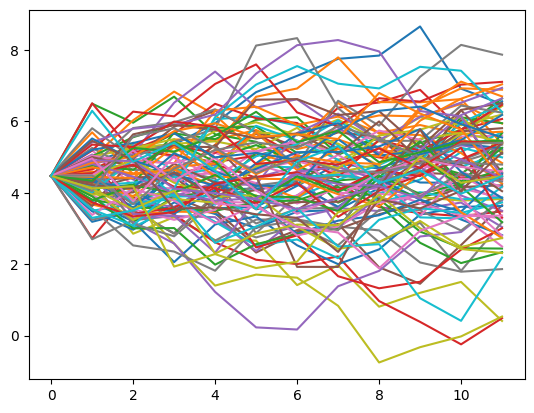

In [986]:
plt.plot(YCOP.T)

In [990]:
t_resumen = pd.DataFrame([YCOF.mean(),YNG.mean(),YCOP.mean()])

In [992]:
t_resumen.index = prices_ia.columns
t_resumen.columns = ['E(Pi)']

In [993]:
t_resumen # Valor esperado de los activos en los proximos 12 meses

,E(Pi)
Coffe,3.601121
Natural Gas,162.145968
Copper,4.477889
